In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# 因为我们的notebook文件位于object_detection文件夹下，
sys.path.append("..")
from object_detection.utils import ops as utils_ops

if StrictVersion(tf.__version__) < StrictVersion('1.12.0'):
  raise ImportError('Please upgrade your TensorFlow installation to v1.12.*.')

from utils import label_map_util
from utils import visualization_utils as vis_util

# 因为执行object_detection_tutorial notebook文件，模型已经下载到本地了，这里直接使用即可。
# 模型
PATH_TO_FROZEN_GRAPH ='ssd_mobilenet_v1_coco_2017_11_17/frozen_inference_graph.pb'
# 标签映射表
PATH_TO_LABELS = 'data/mscoco_label_map.pbtxt'

# 自定义图，然后将模型加载到内存中
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid: # 获取一个文件操作句柄，加载模型文件
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

# 加载标签映射关系文件
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

# 定义2个函数
# 加载图片的函数
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)
# 预测函数
def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in ['num_detections', 'detection_boxes', 'detection_scores','detection_classes', 'detection_masks']: 
                tensor_name = key + ':0' 
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(tensor_name)
                if 'detection_masks' in tensor_dict:
                    # The following processing is only for single image
                    detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
                    detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
                    # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                    real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
                    detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
                    detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
                    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(detection_masks, detection_boxes, image.shape[1], image.shape[2])
                    detection_masks_reframed = tf.cast(tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                    # Follow the convention by adding back the batch dimension
                    tensor_dict['detection_masks'] = tf.expand_dims(detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,feed_dict={image_tensor: image})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict['detection_classes'][0].astype(np.int64)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
            return output_dict

def files_path(path):
    items = os.listdir(path)
    newlist = []
    for item in items:
        if item.endswith(".jpg") or item.endswith(".png"):
            newlist.append(os.path.join(path, item))
    print(newlist)
    return newlist

def detection(paths):
    # Size, in inches, of the output images.
    IMAGE_SIZE = (12, 8)

    # 开始对路径下的每张图片进行预测
    for image_path in paths:
        image = Image.open(image_path)
        # the array based representation of the image will be used later in order to prepare the
        # result image with boxes and labels on it.
        image_np = load_image_into_numpy_array(image)
        # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
        image_np_expanded = np.expand_dims(image_np, axis=0)
        # Actual detection.
        output_dict = run_inference_for_single_image(image_np_expanded, detection_graph)
        # Visualization of the results of a detection.
        vis_util.visualize_boxes_and_labels_on_image_array(
            image_np,
            output_dict['detection_boxes'],
            output_dict['detection_classes'],
            output_dict['detection_scores'],
            category_index,
            instance_masks=output_dict.get('detection_masks'),
            use_normalized_coordinates=True,
            line_thickness=8)
        plt.figure(figsize=IMAGE_SIZE)
        plt.imshow(image_np)
        plt.show()

/Users/zhusheng/anaconda3/envs/django/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/zhusheng/anaconda3/envs/django/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/zhusheng/anaconda3/envs/django/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/zhusheng/anaconda3/envs/django

['test_images/image1.jpg', 'test_images/image2.jpg']


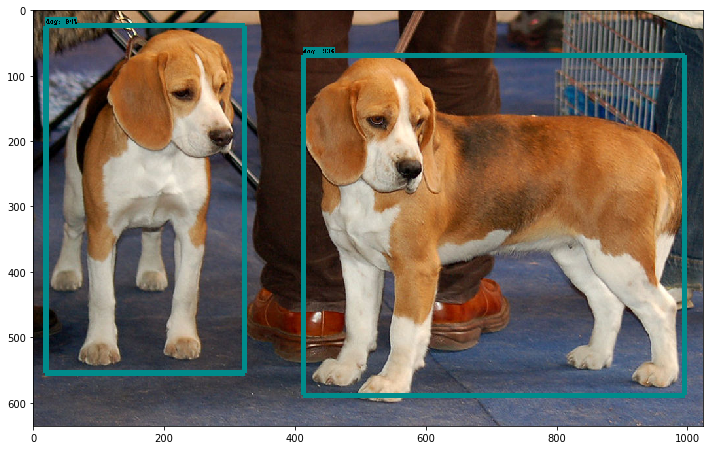

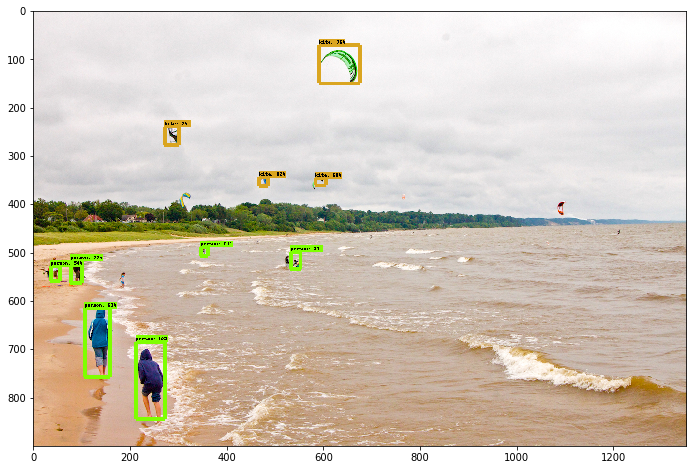

In [2]:
path1 = 'test_images'
paths = files_path(path1)
detection(paths)

['/Users/zhusheng/WorkSpace/Dataset/15-object_detection/image1/image8.jpg', '/Users/zhusheng/WorkSpace/Dataset/15-object_detection/image1/image7.jpg', '/Users/zhusheng/WorkSpace/Dataset/15-object_detection/image1/image6.jpg', '/Users/zhusheng/WorkSpace/Dataset/15-object_detection/image1/image4.jpg', '/Users/zhusheng/WorkSpace/Dataset/15-object_detection/image1/image5.jpg', '/Users/zhusheng/WorkSpace/Dataset/15-object_detection/image1/image1.jpg', '/Users/zhusheng/WorkSpace/Dataset/15-object_detection/image1/image2.jpg', '/Users/zhusheng/WorkSpace/Dataset/15-object_detection/image1/image3.jpg']


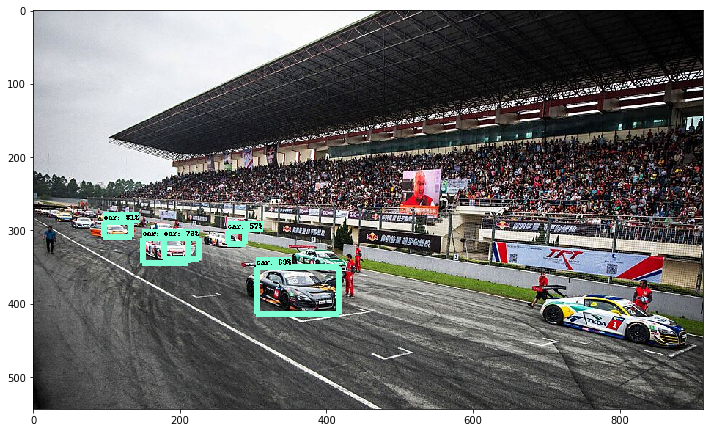

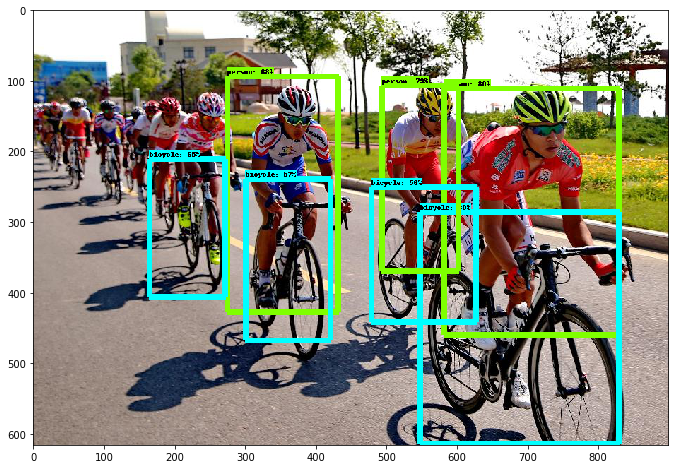

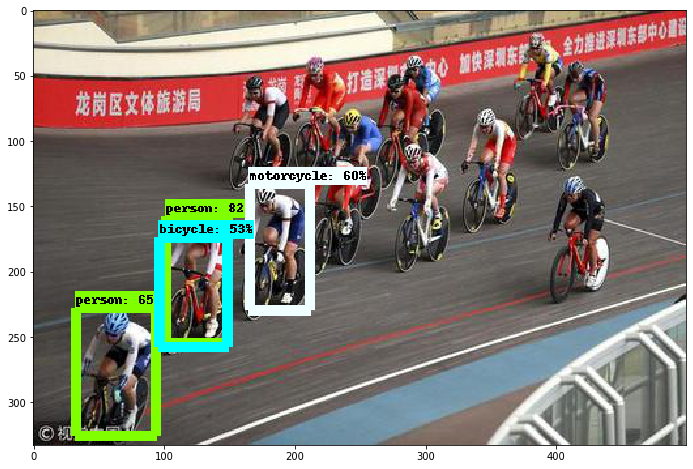

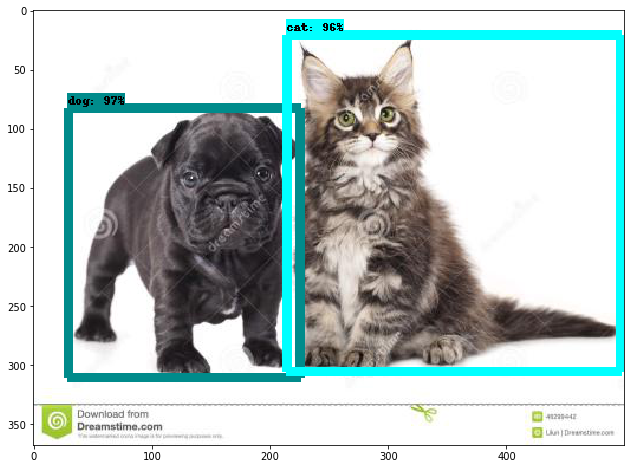

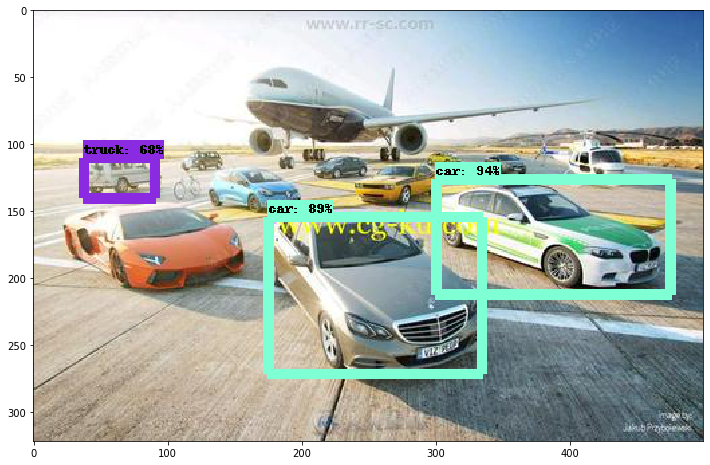

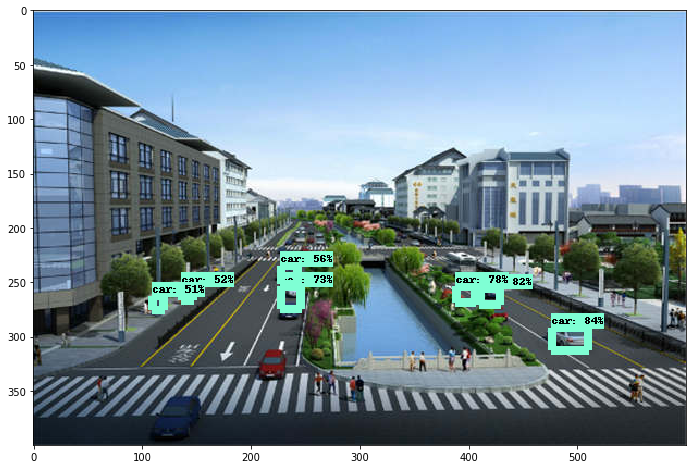

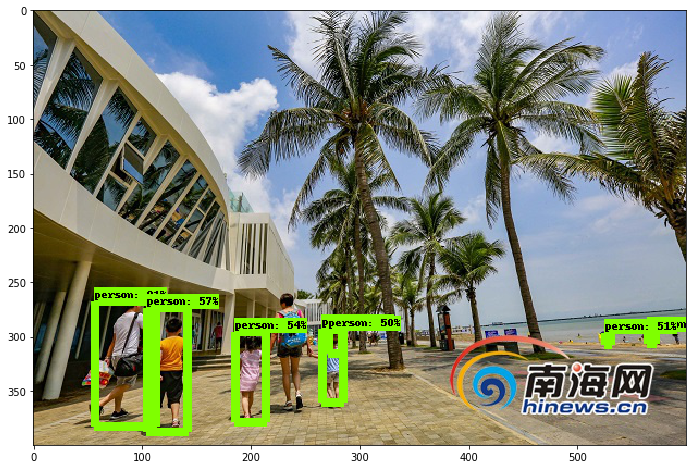

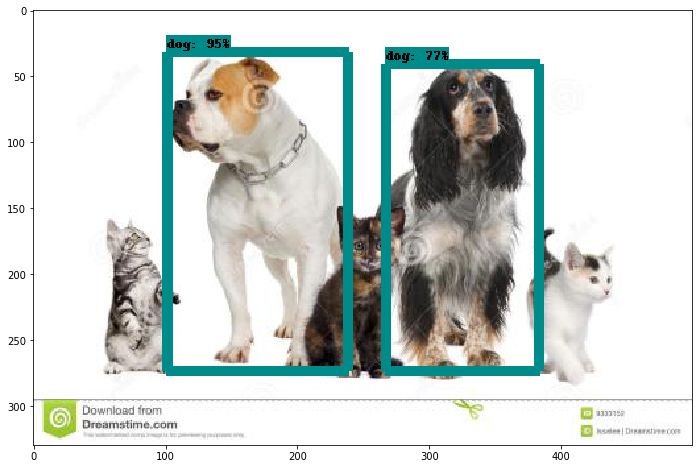

In [3]:
path2 = '/Users/zhusheng/WorkSpace/Dataset/15-object_detection/image1'
paths = files_path(path2)
detection(paths)